OK, we have the data from the TESS Cycle-24 Directors Discretionary Time (DDT) request for [QX Cas](http://simbad.u-strasbg.fr/simbad/sim-basic?Ident=QX+Cas&submit=SIMBAD+search)!

Let's update some figures...

In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from astropy.table import Table
from scipy.optimize import curve_fit
import exoplanet as xo

In [2]:
import matplotlib
matplotlib.rcParams.update({'font.size':18})
matplotlib.rcParams.update({'font.family':'serif'})

# Look at the Data
We've got DDT data for Sector 24, let's make sure all the interesting signals are still present:

- the original 6d period from the former eclipsing binary
- the new 1d eclipse period
- the new 1.7d starspot signal

In [3]:
file = 'tess2019306063752-s0018-0000000326815804-0162-s_lc.fits'
tbl = Table.read(file, format='fits')

file2 = 'tess2020106103520-s0024-0000000326815804-0180-s_lc.fits'
tbl2 = Table.read(file2, format='fits')

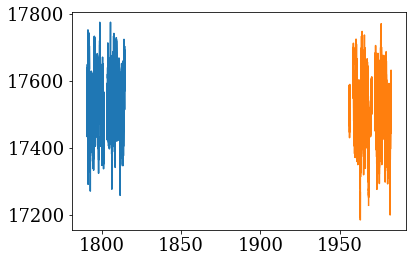

In [4]:
plt.plot(tbl['TIME'], tbl['PDCSAP_FLUX'])
plt.plot(tbl2['TIME'], tbl2['PDCSAP_FLUX'])

In [5]:
df = tbl.to_pandas()
ok = np.where(np.isfinite(df['PDCSAP_FLUX']) & (df['QUALITY']==0))[0]

df2 = tbl2.to_pandas()
ok2 = np.where(np.isfinite(df2['PDCSAP_FLUX']) & (df2['QUALITY']==0))[0]

In [6]:
period_orig = 6.005 # previously published

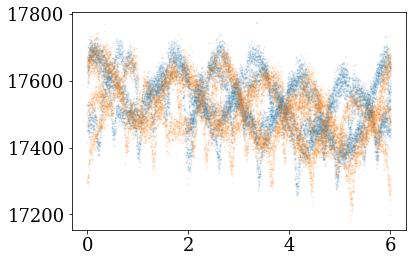

In [7]:
plt.scatter(df['TIME'].values[ok] % period_orig, df['PDCSAP_FLUX'].values[ok], alpha=0.1, s=1)
plt.scatter(df2['TIME'].values[ok2] % period_orig, df2['PDCSAP_FLUX'].values[ok2], alpha=0.1, s=1)

In [8]:
time_all = np.hstack((df['TIME'].values[ok], df2['TIME'].values[ok2]))
flux_all = np.hstack((df['PDCSAP_FLUX'].values[ok], df2['PDCSAP_FLUX'].values[ok2]))

In [9]:
frequency1, power1 = xo.estimators.LombScargle(df['TIME'].values[ok], df['PDCSAP_FLUX'].values[ok]).autopower()
frequency2, power2 = xo.estimators.LombScargle(df2['TIME'].values[ok2], df2['PDCSAP_FLUX'].values[ok2]).autopower()

frequency, power = xo.estimators.LombScargle(time_all, flux_all).autopower()

In [10]:
# This is the new dominant power in the system, coming from starspots?
new_P = 1./frequency[np.argmax(power)]
new_P

1.700237706736282

/Users/james/opt/anaconda3/lib/python3.7/site-packages/IPython/core/pylabtools.py:132: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


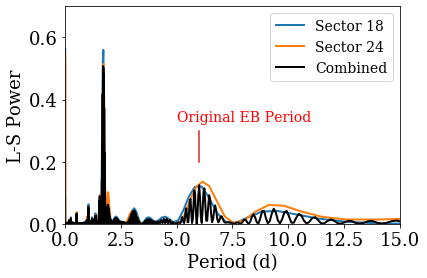

In [11]:
plt.plot(1./frequency1, power1, lw=2, label='Sector 18')
plt.plot(1./frequency2, power2, lw=2, label='Sector 24')
plt.plot(1./frequency, power, lw=2, c='k', label='Combined')

plt.xlim(0, 15)
plt.ylim(0,0.7)
plt.xlabel('Period (d)')
plt.ylabel('L-S Power')

plt.plot([period_orig, period_orig], [0.2,0.3], c='C3')

plt.text(5, 0.33, 'Original EB Period', fontsize=14, color='r')
plt.legend(fontsize=14)

# plt.savefig('LS.png', dpi=150, bbox_inches='tight', pad_inches=0.25)

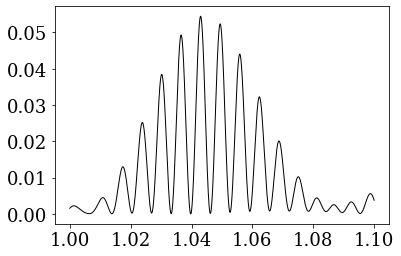

In [12]:
fsup = 1/np.arange(1, 1.1, 0.00001)
psup = xo.estimators.LombScargle(time_all, flux_all).power(fsup)

plt.plot(1./fsup, psup, lw=1, c='k')

1.0429800000002816


/Users/james/opt/anaconda3/lib/python3.7/site-packages/IPython/core/pylabtools.py:132: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


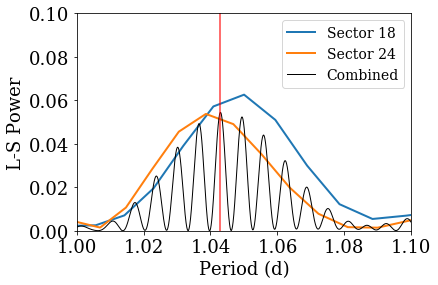

In [13]:
# plt.plot(1./frequency, power, lw=1, c='k')
plt.plot(1./frequency1, power1, lw=2, label='Sector 18')
plt.plot(1./frequency2, power2, lw=2, label='Sector 24')
plt.plot(1./fsup, psup, lw=1, c='k', label='Combined')

# xwin = np.where((1./frequency > 1) & (1./frequency < 1.1))[0]
# pk = np.argmax(power[xwin])
# # the exoplanet candidate period found
# period_p = 1./frequency[xwin][pk]
period_p = 1./fsup[np.argmax(psup)]

plt.plot([period_p, period_p], [0,0.1], c='r', alpha=0.75)

plt.xlim(1,1.1)
plt.ylim(0,0.1)
plt.xlabel('Period (d)')
plt.ylabel('L-S Power')

plt.legend(fontsize=14)
print(period_p)

Text(0.5, 0, 'Phase (P=1.04298d)')

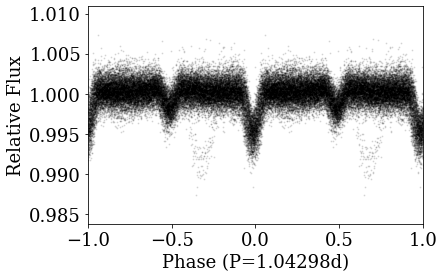

In [14]:
smo = np.hstack((df['PDCSAP_FLUX'][ok].rolling(350, center=True).median(), 
                 df2['PDCSAP_FLUX'][ok2].rolling(350, center=True).median()))

plt.scatter((time_all % period_p) / period_p, 
            (flux_all - smo)/np.nanmedian(flux_all) + 1, alpha=0.1, s=1, c='k')
plt.scatter((time_all % period_p) / period_p - 1,
            (flux_all - smo)/np.nanmedian(flux_all) + 1, alpha=0.1, s=1, c='k')

plt.xlim(-1,1)
plt.ylabel('Relative Flux')
plt.xlabel('Phase (P=1.04298d)')
# plt.savefig('EB.png', dpi=150, bbox_inches='tight', pad_inches=0.25)

# Predicting New Eclipses
We need follow-up data to figure out if this eclipse comes from QX Cas itself, or a nearby star.

TESS data by itself, we can't tell... even a faint background star could easily produce these eclipses in the TESS light curve due to the large aperture.

So we need to catch a future eclipse from APO... 

In [15]:
def _gaus(x, a, b, x0, sigma):
    """
    Simple Gaussian function
    Parameters
    ----------
    x : float or 1-d numpy array
        The data to evaluate the Gaussian over
    a : float
        the amplitude
    b : float
        the constant offset
    x0 : float
        the center of the Gaussian
    sigma : float
        the width of the Gaussian
    Returns
    -------
    Array or float of same type as input (x).
    """
    return a * np.exp(-(x - x0)**2 / (2 * sigma**2)) + b

## Characterize the Eclipse
We got a better eclipse period above, now get rough durations and ephemeris

0.125
-0.01842309151181113


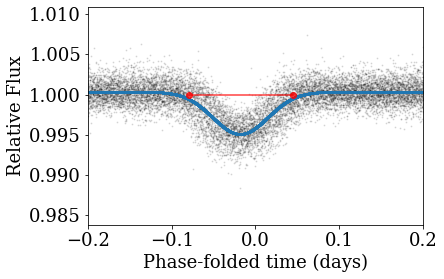

In [16]:
plt.scatter((time_all % period_p), 
            (flux_all - smo)/np.nanmedian(flux_all) + 1, alpha=0.1, s=1, c='k')
plt.scatter((time_all % period_p) - period_p,
            (flux_all - smo)/np.nanmedian(flux_all) + 1, alpha=0.1, s=1, c='k')

plt.xlim(-.2,.2)
plt.ylabel('Relative Flux')
plt.xlabel('Phase-folded time (days)')

# measuring things by-hand...
plt.plot([-0.08, 0.045], [1,1], 'ro-', alpha=0.75)

Edur = 0.045 + 0.08 # days
print(Edur)

p0 = [-0.01, 1, 0., 0.03]
xx = np.hstack(((time_all % period_p), (time_all % period_p) - period_p))
yy = np.hstack(((flux_all - smo)/np.nanmedian(flux_all) + 1, (flux_all - smo)/np.nanmedian(flux_all) + 1))
xxd = np.where((xx > -0.2) & (xx < 0.2) & np.isfinite(xx) & np.isfinite(yy))[0]
popt, pcov = curve_fit(_gaus, xx[xxd], yy[xxd], p0=p0) 

plt.scatter(xx, _gaus(xx, *popt), s=2, alpha=0.5)

E0 = popt[2]
print(E0)

(1976, 1983)

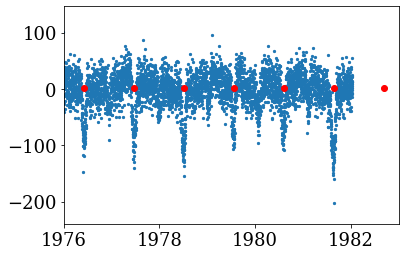

In [17]:
# Looks good...
plt.scatter(time_all, flux_all - smo, s=5)
plt.scatter(np.arange(10000) * period_p + E0, np.ones(10000), c='r')
plt.xlim(1976,1983)

In [18]:
# can we figure if there are any eclipses observable in the evenings in Sept 2020 - Dec 2020?
# est. using the airmass calc here: http://www.briancasey.org/artifacts/astro/airmass.cgi

# follow this tutorial for AstroPlan
# https://astroplan.readthedocs.io/en/latest/tutorials/periodic.html
from astropy.time import Time
import astropy.units as u
from astroplan import EclipsingSystem

primary_eclipse_time = Time(E0 + 2457000., format='jd')
orbital_period = period_p * u.day
eclipse_duration = Edur * u.day

QXcas = EclipsingSystem(primary_eclipse_time = primary_eclipse_time,
                        orbital_period = orbital_period, 
                        duration = eclipse_duration,
                        name='QX Cas')

In [19]:
# SUCH a good orbital period for observing! It shifts by ~an hour each day!
orbital_period.to('hr')

<Quantity 25.03152 h>

In [20]:
observing_time = Time('2020-10-01 00:00')
QXcas.next_primary_eclipse_time(observing_time, n_eclipses=5)

<Time object: scale='utc' format='iso' value=['2020-10-02 00:45:48.709' '2020-10-03 01:47:42.181'
 '2020-10-04 02:49:35.653' '2020-10-05 03:51:29.125'
 '2020-10-06 04:53:22.597']>

In [21]:
from astroplan import FixedTarget, Observer, EclipsingSystem
apo = Observer.at_site('APO', timezone='US/Mountain')
target = FixedTarget.from_name("QX Cas")
target

<FixedTarget "QX Cas" at SkyCoord (ICRS): (ra, dec) in deg (359.67984223, 61.16099259)>

In [22]:
n_transits = 350  # This is the roughly number of transits per year
obs_time = Time('2020-09-01 12:00')
midtransit_times = QXcas.next_primary_eclipse_time(obs_time, n_eclipses=n_transits)


In [23]:
from astroplan import PrimaryEclipseConstraint, is_event_observable, AtNightConstraint, AltitudeConstraint, LocalTimeConstraint
import datetime as dt
min_local_time = dt.time(19, 0)  # 19:00 local time at APO (7pm)
# max_local_time = dt.time(0, 0)  # 00:00 local time at APO (midnight)
max_local_time = dt.time(5, 0)  # 05:00 local time at APO (5am)

constraints = [AtNightConstraint.twilight_civil(),
               AltitudeConstraint(min=30*u.deg),
               LocalTimeConstraint(min=min_local_time, max=max_local_time)]

isobs = is_event_observable(constraints, apo, target, times=midtransit_times)

gdtimes = midtransit_times[np.where(isobs[0])[0]]
for k in range(len(gdtimes)):
    print(k, gdtimes[k])

0 2020-09-09 02:04:12.325
1 2020-09-10 03:06:05.797
2 2020-09-11 04:07:59.269
3 2020-10-03 01:47:42.181
4 2020-10-04 02:49:35.653
5 2020-10-05 03:51:29.125
6 2020-10-06 04:53:22.597
7 2020-10-27 01:31:12.037
8 2020-10-28 02:33:05.509
9 2020-10-29 03:34:58.981
10 2020-10-30 04:36:52.453
11 2020-11-20 01:14:41.893
12 2020-11-21 02:16:35.365
13 2020-11-22 03:18:28.837
14 2020-11-23 04:20:22.309
15 2020-12-14 00:58:11.749
16 2020-12-15 02:00:05.221
17 2020-12-16 03:01:58.693
18 2020-12-17 04:03:52.165
19 2021-01-07 00:41:41.605
20 2021-01-08 01:43:35.077
21 2021-01-09 02:45:28.549
22 2021-01-10 03:47:22.021
23 2021-01-11 04:49:15.493
24 2021-02-01 01:27:04.933
25 2021-02-02 02:28:58.405
26 2021-02-03 03:30:51.877
27 2021-02-26 02:12:28.261
28 2021-08-17 04:24:31.141


# Three Periods

Can we make an empirical model of all three periodic signals?

In [24]:
new_P

1.700237706736282

/Users/james/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:13: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  del sys.path[0]
/Users/james/opt/anaconda3/lib/python3.7/site-packages/IPython/core/pylabtools.py:132: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


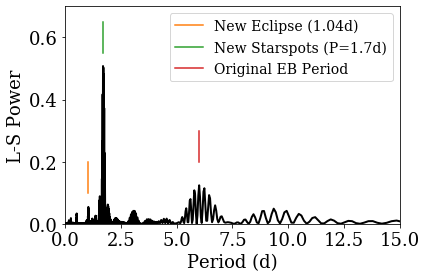

In [25]:
plt.plot(1./frequency, power, lw=2, c='k')

plt.xlim(0, 15)
plt.ylim(0,0.7)
plt.xlabel('Period (d)')
plt.ylabel('L-S Power')

plt.plot([period_p, period_p], [0.1,0.2], c='C1', label='New Eclipse (1.04d)')
plt.plot([new_P, new_P], [0.55,0.65], c='C2', label='New Starspots (P=1.7d)')
plt.plot([period_orig, period_orig], [0.2,0.3], c='C3', label='Original EB Period')

plt.legend(fontsize=14)
plt.savefig('periodogram.png', dpi=150, bbox_inches='tight', pad_inches=0.25)

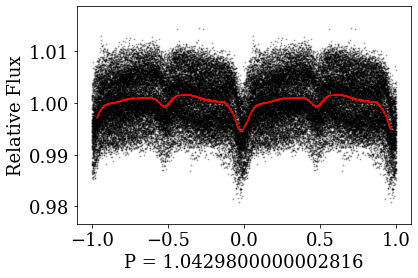

In [26]:
phz1 = np.hstack(((time_all % period_p)/period_p-1, (time_all % period_p)/period_p))
pfl1 = np.tile(flux_all/np.nanmedian(flux_all), 2)

ss1 = np.argsort(phz1)
psmo1 = pd.Series(pfl1[ss1]).rolling(2000, center=True).median()

ind1 = np.hstack((np.arange(len(time_all)), np.arange(len(time_all))))
out1 = np.where((phz1[ss1] >= -0.5) & (phz1[ss1] < 0.5))[0]
sout1 = np.argsort(ind1[ss1][out1])

plt.scatter(phz1, pfl1, s=1, alpha=0.25, c='k')
plt.plot(phz1[ss1], psmo1, c='r')
plt.xlabel('P = '+str(period_p))
plt.ylabel('Relative Flux')
plt.savefig('P1.png', dpi=150, bbox_inches='tight', pad_inches=0.25)

(1790, 1815)

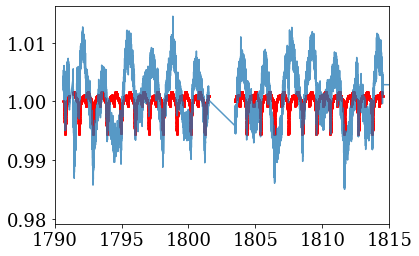

In [27]:
model1 = psmo1[out1].values[sout1] - 1

# now reconstruct the time light curve...
plt.plot(time_all, flux_all/np.nanmedian(flux_all), alpha=0.75)
plt.scatter(time_all, model1+1, c='r', s=2)
plt.xlim(1790,1815)

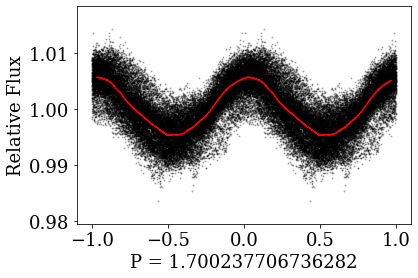

In [28]:
phz2 = np.hstack(((time_all % new_P)/new_P-1, (time_all % new_P)/new_P))
pfl2 = np.tile(flux_all/np.nanmedian(flux_all) - model1, 2)

ss2 = np.argsort(phz2)
psmo2 = pd.Series(pfl2[ss2]).rolling(2000, center=True).median()

ind2 = np.hstack((np.arange(len(time_all)), np.arange(len(time_all))))
out2 = np.where((phz2[ss2] >= -0.5) & (phz2[ss2] < 0.5))[0]
sout2 = np.argsort(ind2[ss2][out2])

plt.scatter(phz2, pfl2, s=1, alpha=0.25, c='k')
plt.plot(phz2[ss2], psmo2, c='r')
plt.xlabel('P = '+str(new_P))
plt.ylabel('Relative Flux')
plt.savefig('P2.png', dpi=150, bbox_inches='tight', pad_inches=0.25)

(1790, 1815)

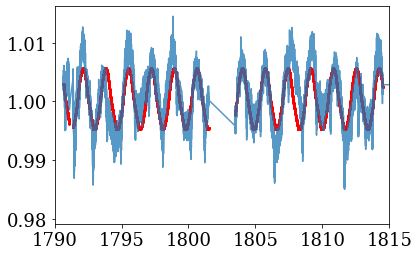

In [29]:
model2 = psmo2[out2].values[sout2] - 1

# now reconstruct the time light curve...
plt.plot(time_all, flux_all/np.nanmedian(flux_all), alpha=0.75)
plt.scatter(time_all, model2+1, c='r', s=2)
plt.xlim(1790,1815)

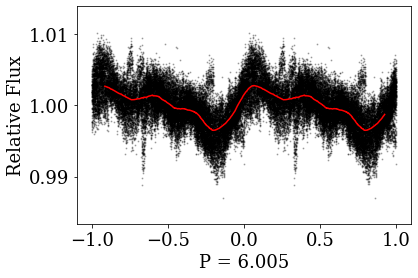

In [30]:
phz3 = np.hstack(((time_all % period_orig)/period_orig-1, (time_all % period_orig)/period_orig))
pfl3 = np.tile(flux_all/np.nanmedian(flux_all) - model1 - model2, 2)

ss3 = np.argsort(phz3)
psmo3 = pd.Series(pfl3[ss3]).rolling(5000, center=True).median()

ind3 = np.hstack((np.arange(len(time_all)), np.arange(len(time_all))))
out3 = np.where((phz3[ss3] >= -0.5) & (phz3[ss3] < 0.5))[0]
sout3 = np.argsort(ind3[ss3][out3])

plt.scatter(phz3, pfl3, s=1, alpha=0.25, c='k')
plt.plot(phz3[ss3], psmo3, c='r')
plt.xlabel('P = '+str(period_orig))
plt.ylabel('Relative Flux')
plt.savefig('P3.png', dpi=150, bbox_inches='tight', pad_inches=0.25)

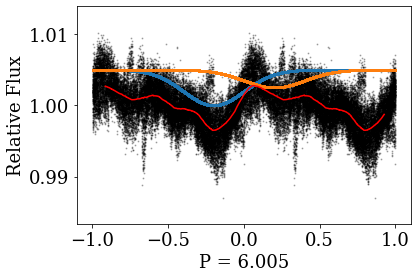

In [31]:
plt.scatter(phz3, pfl3, s=1, alpha=0.25, c='k')
plt.plot(phz3[ss3], psmo3, c='r')
plt.xlabel('P = '+str(period_orig))
plt.ylabel('Relative Flux')

# do we see any evidence of the old primary and eccentric secondary for QX Cas?
plt.scatter(phz3, _gaus(phz3, *(-0.005, 1.005, -0.2, 0.2)), s=2, alpha=0.5)
plt.scatter(phz3, _gaus(phz3, *(-0.0025, 1.005, -0.2 + 0.4, 0.2)), s=2, alpha=0.5)
# not really... we should just run a Phoebe model or something...

# p0 = (-0.005, 1, -0.2, 0.1)
# popt, pcov = curve_fit(_gaus, phz3, pfl3, p0=p0) 
# print(popt)
# plt.scatter(phz3, _gaus(phz3, *popt), s=2, alpha=0.5)

# p0 = (-0.002, 1.004, 0.2, 0.1)
# popt, pcov = curve_fit(_gaus, phz3, pfl3, p0=p0) 
# print(popt)
# plt.scatter(phz3, _gaus(phz3, *popt), s=2, alpha=0.5)


(1790, 1815)

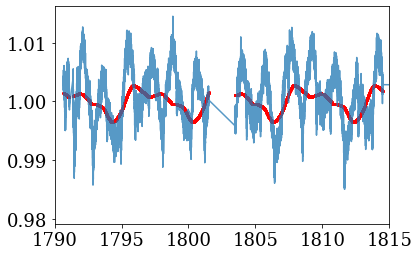

In [32]:
model3 = psmo3[out3].values[sout3] - 1

# now reconstruct the time light curve...
plt.plot(time_all, flux_all/np.nanmedian(flux_all), alpha=0.75)
plt.scatter(time_all, model3+1, c='r', s=2)
plt.xlim(1790,1815)

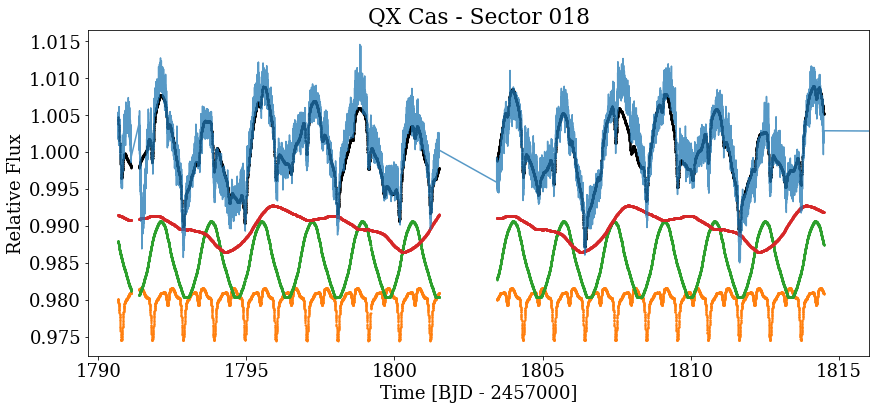

In [33]:
plt.figure(figsize=(14,6))
plt.plot(time_all, flux_all/np.nanmedian(flux_all), alpha=0.75)
plt.scatter(time_all, model1 + model2 + model3+1, c='k', s=1)
plt.scatter(time_all, model1 + .98, c='C1', s=1)
plt.scatter(time_all, model2 + .985, c='C2', s=1)
plt.scatter(time_all, model3 + .99, c='C3', s=1)

plt.xlim(df['TIME'].min()-1, df['TIME'].max()+1)
plt.xlabel('Time [BJD - 2457000]')
plt.ylabel('Relative Flux')
plt.title('QX Cas - Sector 018')
plt.savefig('three_period_S018.png', dpi=150, bbox_inches='tight', pad_inches=0.25)

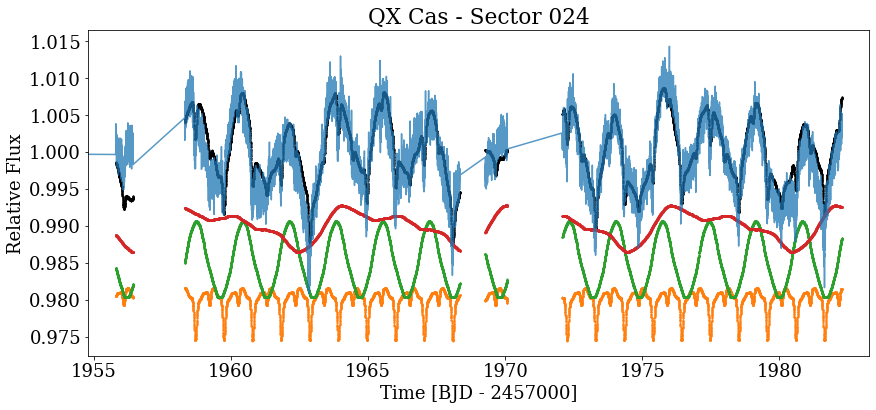

In [34]:
plt.figure(figsize=(14,6))
plt.plot(time_all, flux_all/np.nanmedian(flux_all), alpha=0.75)
plt.scatter(time_all, model1 + model2 + model3+1, c='k', s=1)
plt.scatter(time_all, model1 + .98, c='C1', s=1)
plt.scatter(time_all, model2 + .985, c='C2', s=1)
plt.scatter(time_all, model3 + .99, c='C3', s=1)

plt.xlim(df2['TIME'].min()-1, df2['TIME'].max()+1)
plt.xlabel('Time [BJD - 2457000]')
plt.ylabel('Relative Flux')
plt.title('QX Cas - Sector 024')
plt.savefig('three_period_S024.png', dpi=150, bbox_inches='tight', pad_inches=0.25)

## The Residuals
They look OK... some extra signal near the starspot period, seems reasonable.

The residual stddev is about 2x larger than the typical per-measurment uncertainty.

In [35]:
resid = flux_all/np.nanmedian(flux_all) - (model1 + model2 + model3)
frequencyR, powerR = xo.estimators.LombScargle(time_all, resid).autopower()

/Users/james/opt/anaconda3/lib/python3.7/site-packages/IPython/core/pylabtools.py:132: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


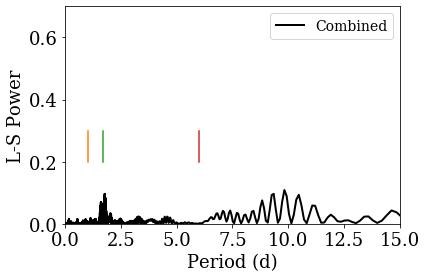

In [36]:
plt.plot(1./frequencyR, powerR, lw=2, c='k', label='Combined')

plt.xlim(0, 15)
plt.ylim(0,0.7)
plt.xlabel('Period (d)')
plt.ylabel('L-S Power')

plt.plot([period_p, period_p], [0.2,0.3], c='C1')
plt.plot([new_P, new_P], [0.2,0.3], c='C2')
plt.plot([period_orig, period_orig], [0.2,0.3], c='C3')
plt.legend(fontsize=14)

(0, 0.2)

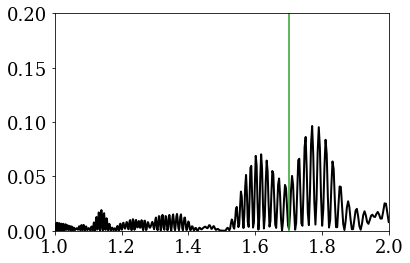

In [37]:
plt.plot(1./frequencyR, powerR, lw=2, c='k', label='Combined')
plt.plot([new_P, new_P], [0.,0.3], c='C2')

plt.xlim(1,2)
plt.ylim(0,0.2)

Text(0, 0.5, 'Relative Flux')

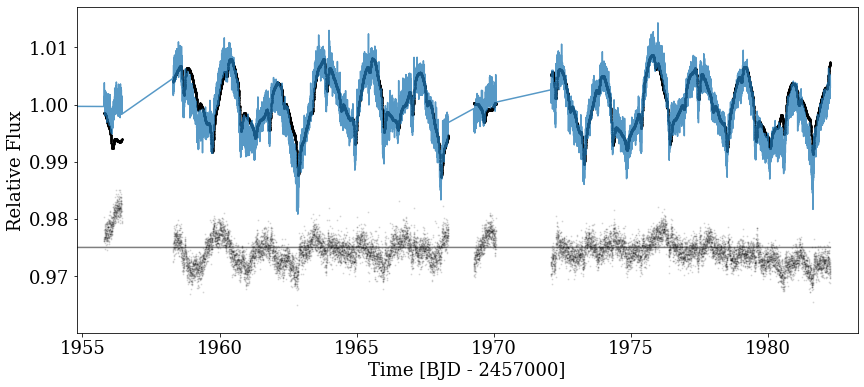

In [38]:
plt.figure(figsize=(14,6))
plt.plot(time_all, flux_all/np.nanmedian(flux_all), alpha=0.75)
plt.scatter(time_all, model1 + model2 + model3+1, c='k', s=1)

plt.scatter(time_all, resid - 0.025, s=1, alpha=0.1, c='k')
plt.plot(time_all, resid*0 + 0.975, c='k', alpha=0.5)
plt.xlim(df2['TIME'].min()-1, df2['TIME'].max()+1)
plt.xlabel('Time [BJD - 2457000]')
plt.ylabel('Relative Flux')

Text(0.5, 0, 'Relative Flux Residuals')

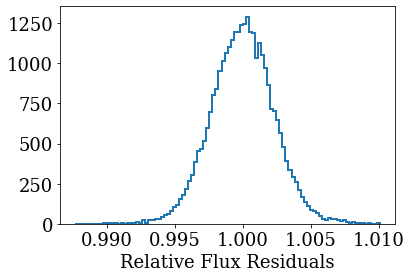

In [39]:
_ = plt.hist(resid, bins=100, histtype='step', lw=2)
np.std(resid)
plt.xlabel('Relative Flux Residuals')

In [40]:
np.nanmedian(df['PDCSAP_FLUX_ERR']/np.nanmedian(df['PDCSAP_FLUX']))

0.00113889